In [8]:
import os
import h5py
import numpy as np
import torch
from torch_geometric.data import Data

# ====================== 1. 定义相对路径（完全匹配你的目录） ======================
# 脚本路径：data/scripts → 数据路径：data/dataset/G_emb.npy（MATLAB 7.3格式）
file_rel_path = "../dataset/G_emb.npy"
file_abs_path = os.path.abspath(file_rel_path)

# 验证文件存在
if not os.path.exists(file_rel_path):
    raise FileNotFoundError(f"文件不存在！路径：{file_abs_path}")

# ====================== 2. 读取数值矩阵（适配你的.Variables提取的array） ======================
with h5py.File(file_rel_path, 'r') as f:
    # --------------------------
    # 1. 读取边的源/目标节点（src/tgt，0-based数值）
    # --------------------------
    # MATLAB列优先 → Python行优先，转置+降维（去除多余维度）
    src = np.squeeze(np.array(f['src']).T)  # 一维数组 (11645,)
    tgt = np.squeeze(np.array(f['tgt']).T)  # 一维数组 (11645,)
    # 构建PyG要求的edge_index（2×E矩阵，第一行源、第二行目标）
    edge_index = np.vstack([src, tgt])      # 维度：(2, 11645)
    
    # --------------------------
    # 2. 读取节点特征矩阵（nodeFeat：.Variables提取的数值矩阵）
    # --------------------------
    # 转置匹配维度（MATLAB列优先→Python行优先），去除冗余维度
    nodeFeat = np.squeeze(np.array(f['nodeFeat']).T)  # 维度：(4301, N)（N为节点特征数）
    
    # --------------------------
    # 3. 读取边特征矩阵（edgeFeat：.Variables提取的数值矩阵）
    # --------------------------
    edgeFeat = np.squeeze(np.array(f['edgeFeat']).T)  # 维度：(11645, M)（M为边特征数）

# ====================== 3. 转换为PyG张量（构建有向图） ======================
# 核心要求：
# - edge_index必须为torch.int64（PyG强制）
# - 节点/边特征为torch.float32（深度学习常用格式）
edge_index = torch.tensor(edge_index, dtype=torch.int64)
x = torch.tensor(nodeFeat, dtype=torch.float32)          # 节点特征 (4301, N)
edge_attr = torch.tensor(edgeFeat, dtype=torch.float32)  # 边特征 (11645, M)

# 构建PyG有向图（天然支持有向，核心是edge_index的方向）
graph_pyg = Data(
    x=x,                # 节点特征矩阵（.Variables提取的数值）
    edge_index=edge_index,  # 有向边索引（src→tgt）
    edge_attr=edge_attr     # 边特征矩阵（.Variables提取的数值）
)

# ====================== 4. 验证读取结果（匹配你的数据维度） ======================
print("===== 读取结果验证 =====")
print(f"文件路径：{file_abs_path}")
print(f"edge_index维度：{edge_index.shape}")  # 预期 (2, 11645)
print(f"节点特征维度：{x.shape}")            # 预期 (4301, 特征数)
print(f"边特征维度：{edge_attr.shape}")      # 预期 (11645, 特征数)
print(f"PyG有向图节点数：{graph_pyg.num_nodes}")  # 4301（由x的行数自动推断）
print(f"PyG有向图边数：{graph_pyg.num_edges}")    # 11645
print(f"是否为有向图：{graph_pyg.is_directed()}") # True

===== 读取结果验证 =====
文件路径：e:\我的文件\大学学习\_硕士学习\毕设硕士\车辆控制算法开发\Compass-Predictive-Driving\data\dataset\G_emb.npy
edge_index维度：torch.Size([2, 11645])
节点特征维度：torch.Size([4301, 14])
边特征维度：torch.Size([11645, 2])
PyG有向图节点数：4301
PyG有向图边数：11645
是否为有向图：True


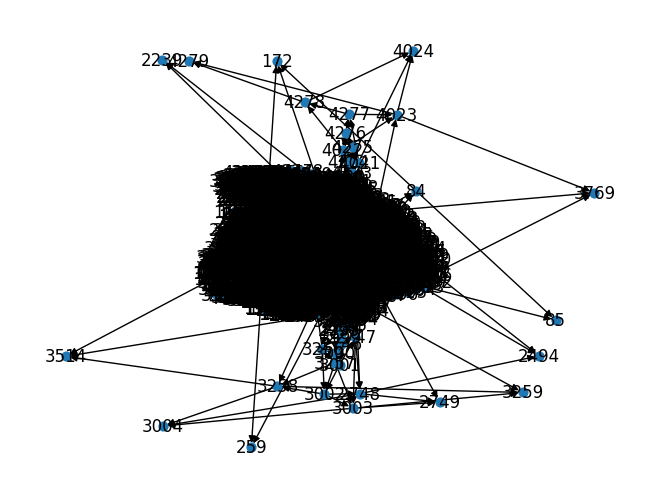

In [10]:
# 可视化有向图
import networkx as nx

# 将graph_pyg转换为networkx图
G = nx.DiGraph()

# 添加节点
G.add_nodes_from(range(graph_pyg.x.shape[0]))

# 添加边
edge_index = graph_pyg.edge_index.numpy()
G.add_edges_from(edge_index.T)

# 绘制图形
pos = nx.spring_layout(G) 
nx.draw(G, pos, with_labels=True, node_size=40)



In [7]:

print(graph_pyg)

Data(edge_index=[2, 11645], node_var_names=[60214], edge_var_names=[23290])


In [11]:
pos

{0: array([0.33807793, 0.02354922]),
 1: array([0.32600132, 0.05636873]),
 2: array([0.29953212, 0.08908127]),
 3: array([0.2642169 , 0.11933506]),
 4: array([0.22207069, 0.14571977]),
 5: array([0.17795695, 0.16079845]),
 6: array([0.13033502, 0.16882549]),
 7: array([0.07925927, 0.16839027]),
 8: array([0.02656685, 0.15847197]),
 9: array([-0.02023048,  0.13711523]),
 10: array([-0.06476671,  0.10864491]),
 11: array([-0.10527665,  0.07515253]),
 12: array([-0.14884284,  0.03828181]),
 13: array([-0.1931255 ,  0.00220881]),
 14: array([-0.24137653, -0.02690068]),
 15: array([-0.29085311, -0.03884658]),
 16: array([-0.28568038, -0.02330846]),
 17: array([-0.25378227, -0.01849391]),
 18: array([-0.21108875, -0.01136671]),
 19: array([-0.16770595, -0.00808137]),
 20: array([-0.13164777, -0.00731918]),
 21: array([-0.08901647, -0.00683645]),
 22: array([-0.04718701, -0.00517122]),
 23: array([-0.00369235, -0.00460225]),
 24: array([ 0.04026464, -0.0036951 ]),
 25: array([0.08281428, 0.00

In [19]:
graph_pyg.x

tensor([[5.9678e+04, 8.6850e+04, 2.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [5.9678e+04, 8.6847e+04, 2.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [5.9678e+04, 8.6845e+04, 2.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [5.9944e+04, 8.6609e+04, 1.0000e-01,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [5.9945e+04, 8.6609e+04, 1.0000e-01,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [5.9945e+04, 8.6610e+04, 1.0000e-01,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])

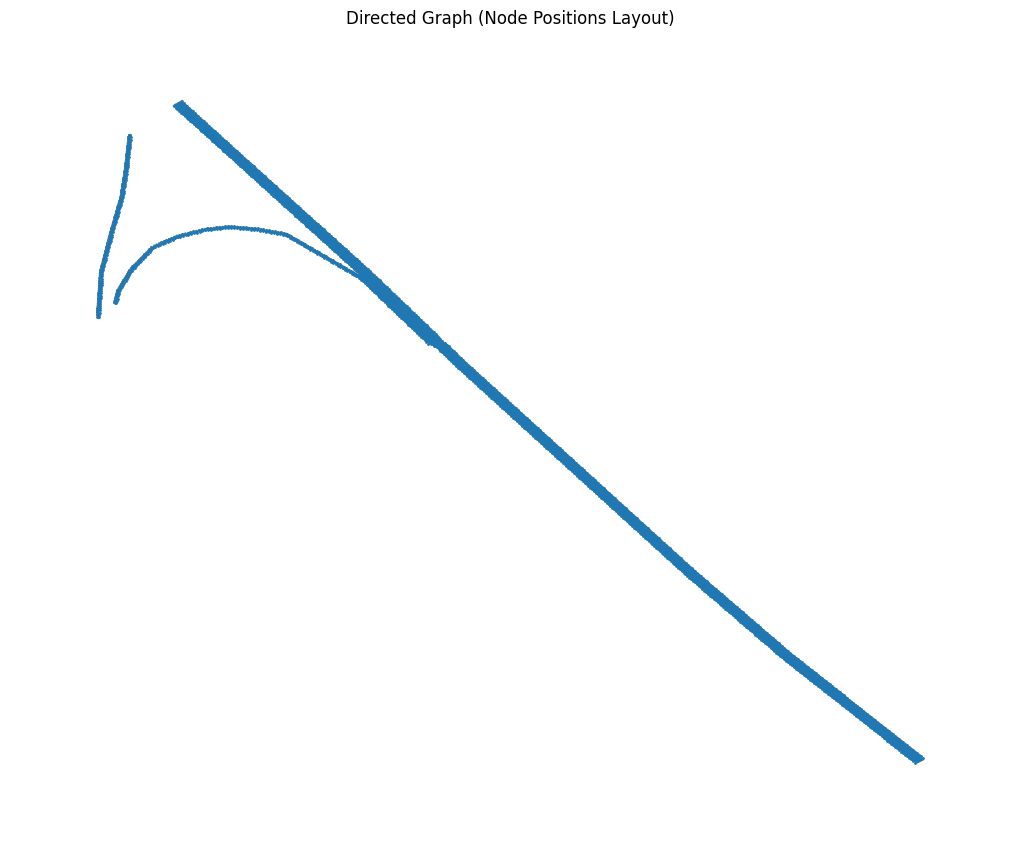

In [ ]:
# 可视化有向图
import networkx as nx
import matplotlib.pyplot as plt

# 将graph_pyg转换为networkx图
G = nx.DiGraph()

# 添加节点
num_nodes = graph_pyg.x.shape[0]
G.add_nodes_from(range(num_nodes))

# 添加边
edge_index = graph_pyg.edge_index.numpy()
G.add_edges_from(edge_index.T)

# ====================== 核心：将graph_pyg.x的前两列转换为pos格式 ======================
# 1. 提取x的前两列（节点物理位置），转换为numpy数组
# （若tensor在GPU上，需先加.cpu()，如：graph_pyg.x[:, :2].cpu().detach().numpy()）
node_positions = graph_pyg.x[:, :2].detach().numpy()

# 2. 构建pos字典：键=节点索引，值=对应坐标数组
pos = {}
for node_idx in range(num_nodes):
    pos[node_idx] = node_positions[node_idx]  # 每个节点对应前两列的坐标

# ====================== 绘制图形 ======================
plt.figure(figsize=(10, 8))  # 调整画布大小，避免节点重叠
nx.draw(
    G, 
    pos=pos,          # 使用转换后的物理位置pos
    with_labels=False, # 节点数量多的话建议关闭标签（避免混乱）
    node_size=1,     # 节点大小
    edge_color="#888888", # 边颜色浅一点，突出节点
    arrowsize=1       # 有向边箭头大小
)
plt.title("Directed Graph (Node Positions Layout)")
plt.show()

